In [ ]:
# ==================================================
# 0. 의존성
# ==================================================
import torch, numpy as np, torch.nn as nn
import torch.autograd as autograd
from torch.nn.utils import spectral_norm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split, ConcatDataset
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NORMAL_DIGITS, ANOMALY_DIGIT = list(range(1, 10)), 0   # 1‑9 = 정상, 0 = 이상
LATENT_DIM, IMG_SIZE       = 8, 28                   # latent↑
BATCH, EPOCHS, TH_PCT      = 128, 100, 95
LR_G, LR_D                 = 1e-4, 2.5e-5               # G 더 빠르게
lambda_gp, lambda_con, lambda_lat         = 0, 5, 5
ALPHA                      = 0.9                      # score 가중치


In [ ]:
# ==================================================
# 1. 데이터 셋업 (train / val / test)
# ==================================================
tf = transforms.ToTensor()
mnist_train = datasets.MNIST("mnist", train=True,  download=True, transform=tf)
mnist_test  = datasets.MNIST("mnist", train=False, download=True, transform=tf)

normal_idx  = [i for i, (_, y) in enumerate(mnist_train) if y in NORMAL_DIGITS]
normal_ds   = Subset(mnist_train, normal_idx)

n_train = int(0.9 * len(normal_ds))
train_ds, val_ds = random_split(
    normal_ds, [n_train, len(normal_ds) - n_train],
    generator=torch.Generator().manual_seed(42))

anom_idx   = [i for i, (_, y) in enumerate(mnist_test) if y == ANOMALY_DIGIT]
# test = val(정상) + 0(이상)
test_ds    = ConcatDataset([val_ds, Subset(mnist_test, anom_idx)])

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.92MB/s]


In [ ]:
# ==================================================
# 2. 네트워크 (GANomaly)
# ==================================================
def conv_block(in_c, out_c, *, k=3, s=2, p=1, bn=True, spec=False):  # ★ k=3
    conv = nn.Conv2d(in_c, out_c, k, s, p)
    if spec:
        conv = spectral_norm(conv)
    layers = [conv]
    if bn:
        layers.append(nn.BatchNorm2d(out_c))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)

class Generator(nn.Module):
    """Encoder‑Decoder‑Encoder (stride‑2, k=3)"""
    def __init__(self, zdim=LATENT_DIM):
        super().__init__()
        # E₁ : 28→14→7→4
        self.enc1 = nn.Sequential(
            conv_block(1,   32),
            conv_block(32,  64),
            conv_block(64, 128),
            nn.Flatten())
        self.fc_z  = nn.Linear(128 * 4 * 4, zdim)          # ★ 4×4
        # D : 4→8→16→32 → crop 28
        self.fc_dec = nn.Linear(zdim, 128 * 4 * 4)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(True),
            nn.ConvTranspose2d(32, 1,  4, 2, 1), nn.Tanh())
        # E₂
        self.enc2 = nn.Sequential(
            conv_block(1,   32),
            conv_block(32,  64),
            conv_block(64, 128),
            nn.Flatten())
        self.fc_z2 = nn.Linear(128 * 4 * 4, zdim)

    def forward(self, x):
        z  = self.fc_z(self.enc1(x))
        xh = self.fc_dec(z).view(-1, 128, 4, 4)
        xh = self.dec(xh)[:, :, :28, :28]                   # crop
        z2 = self.fc_z2(self.enc2(xh))
        return xh, z, z2

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            conv_block(1,   32, spec=True, bn=False),
            conv_block(32,  64, spec=True),
            conv_block(64, 128, spec=True),
            conv_block(128,256, spec=True),

            spectral_norm(nn.Conv2d(256, 1, 3, 1, 1)))
    def forward(self, x):
        return self.net(x)

G, D = Generator().to(DEVICE), Discriminator().to(DEVICE)


In [ ]:
# ==================================================
# 3. 학습 루프 (WGAN-GP + ℓ_con + ℓ_lat)
# ==================================================
opt_G = torch.optim.Adam(G.parameters(), LR_G, betas=(0.0, 0.9))
opt_D = torch.optim.Adam(D.parameters(), LR_D, betas=(0.0, 0.9))

def gradient_penalty(x_real, x_fake):
    a_weights = torch.rand(x_real.size(0), 1, 1, 1, device=DEVICE)
    hat = (a_weights * x_real + (1 - a_weights) * x_fake).requires_grad_(True)
    d_hat = D(hat)
    grad  = autograd.grad(d_hat.sum(), hat, create_graph=True)[0]
    gp    = (grad.flatten(1).norm(2, dim=1) - 1).pow(2).mean()
    return gp

for ep in range(1, EPOCHS + 1):
    G.train(); D.train()
    g_sum = d_sum = 0.
    n_critic = 5

    for i, (x, _) in enumerate(train_loader):
        x = x.to(DEVICE) * 2 - 1                      # [-1,1]
        # ----- D -----
        with torch.no_grad():
            x_fake, _, _ = G(x)
        loss_D = -(D(x).mean() - D(x_fake).mean()) + lambda_gp * gradient_penalty(x, x_fake)

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # ----- G -----
        if i % n_critic == 0:
            x_fake, z, z2 = G(x)

            adv = -D(x_fake).mean()

            xt, xft = (x + 1) / 2, (x_fake + 1) / 2

            con = (xt - xft).pow(2).mean()
            lat = (z - z2).pow(2).mean()

            loss_G = adv + lambda_con * con + lambda_lat * lat

            opt_G.zero_grad(); loss_G.backward(); opt_G.step()

            g_sum += loss_G.item() * x.size(0)
            d_sum += loss_D.item() * x.size(0)

    print(f"[{ep:03}/{EPOCHS}]  L_G={g_sum/len(train_ds):.4f}  L_D={d_sum/len(train_ds):.4f}")


[001/100]  L_G=1.4547  L_D=-2.1119
[002/100]  L_G=1.9693  L_D=-3.3742
[003/100]  L_G=2.1059  L_D=-3.7381
[004/100]  L_G=2.1106  L_D=-3.8142
[005/100]  L_G=2.0991  L_D=-3.8639
[006/100]  L_G=2.0960  L_D=-3.9135
[007/100]  L_G=2.1049  L_D=-3.9630
[008/100]  L_G=2.1190  L_D=-4.0126
[009/100]  L_G=2.1370  L_D=-4.0621
[010/100]  L_G=2.1547  L_D=-4.1117
[011/100]  L_G=2.1735  L_D=-4.1612
[012/100]  L_G=2.1945  L_D=-4.2107
[013/100]  L_G=2.2131  L_D=-4.2602
[014/100]  L_G=2.2335  L_D=-4.3097
[015/100]  L_G=2.2539  L_D=-4.3592
[016/100]  L_G=2.2759  L_D=-4.4092
[017/100]  L_G=2.2987  L_D=-4.4614
[018/100]  L_G=2.3255  L_D=-4.5222
[019/100]  L_G=2.3665  L_D=-4.6058
[020/100]  L_G=2.3909  L_D=-4.6614
[021/100]  L_G=2.4141  L_D=-4.7118
[022/100]  L_G=2.4371  L_D=-4.7619
[023/100]  L_G=2.4610  L_D=-4.8121
[024/100]  L_G=2.4853  L_D=-4.8623
[025/100]  L_G=2.5085  L_D=-4.9125
[026/100]  L_G=2.5316  L_D=-4.9626
[027/100]  L_G=2.5558  L_D=-5.0127
[028/100]  L_G=2.5806  L_D=-5.0629
[029/100]  L_G=2.603

In [ ]:
# ==================================================
# 4. 임계치 계산 (train+val 정상 90-percentile)
# ==================================================
ALPHA   = 0.9          #  ℓ_con ↔ ℓ_lat 가중치
TH_PCT  = 90           #  퍼센타일 기준
DEVICE  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- GANomaly 스코어 함수 -----------------------------------------
def anomaly_score(x):
    """
    반환값
      score : (B,)  텐서
      x_hat : (B,C,H,W) 재구성 이미지
    공식  a_weights·ℓ_con + (1-a_weights)·ℓ_lat
    """
    x_hat, z, z_hat = G(x)                       # Generator는 3개 반환

    # [-1,1] → [0,1]로 맞춰서 픽셀 MSE 계산
    xt, xh_t = (x + 1) / 2, (x_hat + 1) / 2

    con = (xt - xh_t ).pow(2).mean([1, 2, 3])    # ℓ_con  (pixel)
    lat = (z  - z_hat).pow(2).mean(1).sqrt()     # ℓ_lat  (feature)
    return ALPHA * con + (1 - ALPHA) * lat, x_hat


# --- ① val 데이터(정상) 스코어 수집 -------------------------------
G.eval(); scores_val = []

with torch.no_grad():
    for x, _ in val_loader:
        x = x.to(DEVICE) * 2 - 1                 # [0,1] → [-1,1]
        sc, _ = anomaly_score(x)                 # sc : (B,)
        scores_val.extend(sc.cpu().numpy())

# --- ② 95-percentile 임계치 계산 ----------------------------------
scores_val = np.asarray(scores_val)
THRESH = np.percentile(scores_val, TH_PCT)
print(f"\n[Threshold] {TH_PCT}-percentile = {THRESH:.6f}")



[Threshold] 90-percentile = 0.039347


In [ ]:
# ==================================================
# 5. 테스트 평가
# ==================================================
G.eval(); y_true, y_score, recon_store = [], [], []
with torch.no_grad():
    for x, y in test_loader:
        x  = x.to(DEVICE) * 2 - 1
        sc, xh = anomaly_score(x)
        y_score.extend(sc.cpu().numpy())
        y_true.extend((y == ANOMALY_DIGIT).int().numpy())
        recon_store.append((x.cpu(), xh.cpu()))

auc = roc_auc_score(y_true, y_score)
ap  = average_precision_score(y_true, y_score)
print(f"[Test]  AUROC = {auc:.4f}   AUPRC = {ap:.4f}")

[Test]  AUROC = 0.9348   AUPRC = 0.6515


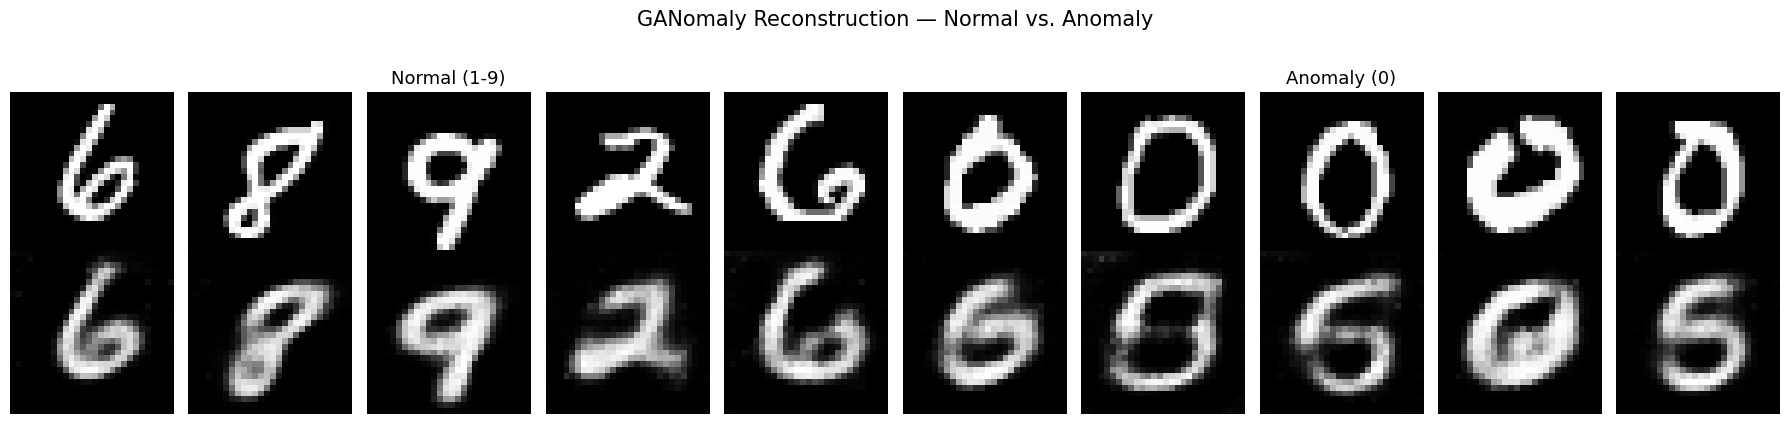

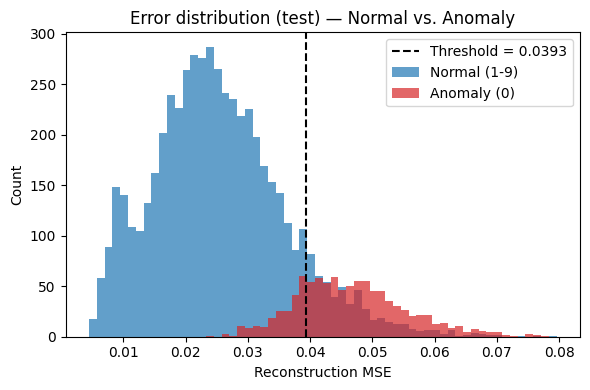

In [ ]:
# ==================================================
# 6. 시각화
# ==================================================
# 6-1. 입력 ↔ 재구성 (정상 5장, 이상 5장)
norm_pairs, anom_pairs = [], []

for (x_batch, xh_batch), (_, y_batch) in zip(recon_store, test_loader):
    for img, rec, label in zip(x_batch, xh_batch, y_batch):
        label_val = label.item()
        pair = (img.add(1).div(2), rec.add(1).div(2))        # [0, 1] 복원
        if label_val == ANOMALY_DIGIT and len(anom_pairs) < 5:
            anom_pairs.append(pair)
        elif label_val != ANOMALY_DIGIT and len(norm_pairs) < 5:
            norm_pairs.append(pair)
    if len(norm_pairs) == 5 and len(anom_pairs) == 5:
        break

fig, axes = plt.subplots(2, 10, figsize=(18, 4))
for col, (inp, rec) in enumerate(norm_pairs + anom_pairs):
    axes[0, col].imshow(inp.squeeze(), cmap="gray");  axes[0, col].axis("off")
    axes[1, col].imshow(rec.squeeze(), cmap="gray");  axes[1, col].axis("off")
axes[0, 0].set_ylabel("Input", fontsize=12)
axes[1, 0].set_ylabel("Recon", fontsize=12)
axes[0, 2].set_title("Normal (1-9)", fontsize=13)
axes[0, 7].set_title("Anomaly (0)",  fontsize=13)
plt.suptitle("GANomaly Reconstruction — Normal vs. Anomaly", y=1.05, fontsize=15)
plt.tight_layout()
plt.show()

# 6-2. 오차 히스토그램 (정상·이상 색상 구분)
err_tensor   = torch.tensor(y_score)
label_tensor = torch.tensor(y_true)                # 0 = 정상, 1 = 이상

err_norm = err_tensor[label_tensor == 0]
err_anom = err_tensor[label_tensor == 1]

bins = 60
hist_norm, edges = torch.histogram(err_norm, bins=bins)
hist_anom, _     = torch.histogram(err_anom, bins=edges)     # 동일 bin 사용
centers = (edges[:-1] + edges[1:]) / 2
width   = centers[1] - centers[0]

plt.figure(figsize=(6, 4))
plt.bar(centers.numpy(), hist_norm.numpy(),
        width=width, color="#1f77b4", alpha=0.7, label="Normal (1-9)")
plt.bar(centers.numpy(), hist_anom.numpy(),
        width=width, color="#d62728", alpha=0.7, label="Anomaly (0)")
plt.axvline(THRESH, linestyle="--", color="k", label=f"Threshold = {THRESH:.4f}")

plt.xlabel("Reconstruction")
plt.ylabel("Count")
plt.title("Error distribution (test) — Normal vs. Anomaly")
plt.legend()
plt.tight_layout()
plt.show()